In [43]:
# https://github.com/sammchardy/python-binance
# https://binance-docs.github.io/apidocs/#order-book

import json
import os
from binance.client import Client

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

os.chdir('/Users/uknowit/Binance')

with open('api_key.json') as json_file:
    api_stuff = json.load(json_file)

KEY = api_stuff['api_key']
SECRET = api_stuff['secret'] 

In [44]:
client = Client(KEY, SECRET, {"verify": False, "timeout": 20})

In [102]:
def simulate_profit_general(df, quantity = 1, signal_name = 'signal'):
    return quantity * df["close"] * df[signal_name]

def simulate_profit(df, quantity = 1):
    return quantity * df.close * df.cross

class Klines():
    def __init__(self, klines_list):
        self.list = klines_list
        self.dict = self.to_dict(self.list)
        self.df = self.to_df(self.list)
        self.df_sultan = self.consecutive_green_klines()
#         self.ma_close_df = self.df_MA_close()
#         self.ema_close_df = self.df_EMA_close()
#         self.ma_profit = self.MA_close_profit(intersects = ['ma_s', 'ma_l'], is_ema = False)
#         self.ema_profit = self.MA_close_profit(intersects = ['ema_s', 'ema_l'], is_ema = True)
       
    
    def to_dict(self, klines):
        ''' Creates a dict of dicts with the kline key = open_time of the kline'''

        kline_dict = dict()
        for kline in klines:
            kline_to_add = {
                kline[0]: {
                    "open_time": kline[0],
                    "open": kline[1],
                    "high": kline[2],
                    "low": kline[3],
                    "close": kline[4],
                    "volume": kline[5],
                    "close_time": kline[6],
                    "quote_asset_volume": kline[7],
                    "no_of_trades": kline[8],
                    "taker_buy_base_asset_volume": kline[9],
                    "taker_buy_quote_asset_volume": kline[10],
                }
            }
            kline_dict.update(kline_to_add)
        return kline_dict

    def to_df(self, klines):
        kline_columns = [
                "open_time",
                "open",
                "high",
                "low",
                "close",
                "volume",
                "close_time",
                "quote_asset_volume",
                "no_of_trades",
                "taker_buy_base_asset_volume",
                "taker_buy_quote_asset_volume",
                "ignore"
                ]
        df = pd.DataFrame(klines, columns = kline_columns)
        df = df.apply(pd.to_numeric, errors = 'coerce')
        df["open_time"] = pd.to_datetime(df.open_time, unit='ms')
        df["close_time"]= pd.to_datetime(df.close_time, unit = 'ms')
#         df.drop(columns=["ignore","taker_buy_base_asset_volume","taker_buy_quote_asset_volume"], inplace = True)
        df.index = df.open_time
        return df
    
    def df_MA_close(self, time_interval = [5, 40, 200]):
        df = self.df
        closing_MA_s = df["close"].rolling(time_interval[0], min_periods=time_interval[0]).mean()
        closing_MA_m = df["close"].rolling(time_interval[1], min_periods= time_interval[1]).mean()
        closing_MA_l = df["close"].rolling(time_interval[2], min_periods= time_interval[2]).mean()
        
        df["ma_s"] = closing_MA_s
        df["ma_m"] = closing_MA_m
        df["ma_l"] = closing_MA_l
        
        ma_close_df = df[["close", "ma_s", "ma_m", "ma_l"]]
        
        return ma_close_df
    
    def df_EMA_close(self, time_interval = [5, 10, 20]):
        df = self.df
        closing_EMA_s = df["close"].ewm(span = time_interval[0]).mean()
        closing_EMA_m = df["close"].ewm(span = time_interval[1]).mean()
        closing_EMA_l = df["close"].ewm(span = time_interval[2]).mean()
        
        df["ema_s"] = closing_EMA_s
        df["ema_m"] = closing_EMA_m
        df["ema_l"] = closing_EMA_l
        
        ema_close_df = df[["close", "ema_s", "ema_m", "ema_l"]]
        
        return ema_close_df
    
    def consecutive_green_klines(self):
        df = self.df
        
        is_green = (df["close"] > df["open"]).astype(int)
        is_consecutive_green = is_green * is_green.shift(1)
        
        is_no_trades_increase = (df["no_of_trades"] - df["no_of_trades"].shift(1) > 0).astype(int)
        
        # 1 means is buy signal, 0 means not buy signal
        is_buy_signal = is_consecutive_green * is_no_trades_increase
        
        signal = is_buy_signal.shift(1)
        
        profit = (df["close"] - df["open"])*signal
        
        df['sultan_order_profit'] = profit
        
        df['sultan_cum_profit'] = profit.cumsum()
        
        df_sultan = df[["open", "close", "sultan_order_profit", "sultan_cum_profit", "no_of_trades"]]
        
        return df_sultan
    

    def MA_close_profit(self, intersects = ["ma_s", "ma_l"], is_ema = False):
        
        '''
        Calculates simulated profit if bought at crossings of smaller moving average with longer moving average
        Smaller moving average > Longer moving average --> buy, else sell
        To specify EMA instead of ma, simply specify is_ema = True
        '''
    
    
        if is_ema:
            # Ensure that ema is specified in intervals, otherwise fix it
            for i, intersect in enumerate(intersects):
                if intersect[0] != 'e':
                    intersects[i] = 'e' + intersect
            #Now get corresponding df
            try:
                df = self.ema_close_df
            except:
                print("no ema_close_df found")
                return
        
                
        else:
            try:
                df = self.ma_close_df
            except:
                print("no ma_close_df found")
                return
        
#         Abusing fact that s > m > l in alphabetic order
        assert intersects[0].split('_')[-1] > intersects[1].split('_')[-1], "time trends wrong way around"
        
        try:
            ma_s = df[intersects[0]]
            ma_l = df[intersects[1]]
        except:
            print('intersects missspecified, enter as ma_s, ma_m, ma_l only')
            print(is_ema)
            return
        
        # Positive value indicates buy signal, negative indicates sell. 
        #This checks if todays value is greater than yesterdays. If yes, 1, if no change 0 if less than, -1
        cross = (ma_s - ma_l > 0).astype(int) - (ma_s.shift(1) - ma_l.shift(1) >0).astype(int)
        
        # Do not buy or sell first and last period
        cross[0], cross[-1] = (0, 0)
        
#         Here, the trader is not able to react directly, instead trades on the next day, ie if it crossed yesterday
        self.df["cross"] = cross
#     Here, the trader trades ideally
        #self.df["cross"] = cross(-1)
        
        orders = self.df.apply(simulate_profit, axis = 1)
        
        self.df["orders"] = orders
        
        absolute_profit = cross.sum()* df.close[-1] - orders.sum()
        percent_return = absolute_profit / df.close[-1]
        
        return (absolute_profit, percent_return)
    

In [103]:
klines_dict = dict()

symbols = ["ETHUSDT", "BTCUSDT", "BCHUSDT", "XMRUSDT", "LTCUSDT"]
for symbol in symbols:
    klines = Klines(client.futures_klines(symbol = symbol, interval = client.KLINE_INTERVAL_4HOUR, limit = 1000))
    klines_dict.update({symbol : klines})


In [40]:
print("With the moving average strat you would make:")
for symbol in klines_dict:
    profit = klines_dict.get(symbol).ma_profit
    print(f"{profit[-1] * 100}% in {symbol}")
    
print("With the exponential moving average strat you would make:")
for symbol in klines_dict:
    profit = klines_dict.get(symbol).ema_profit
    print(f"{profit[-1] * 100}% in {symbol}")
    

With the moving average strat you would make:
-0.24578003134067794% in ETHUSDT
-2.5745953559742527% in BTCUSDT
2.392860492013388% in BCHUSDT
-3.4015737065664275% in XMRUSDT
0.4817458935515938% in LTCUSDT


In [100]:
# pd.set_option('display.max_rows', None)
print("With Sultans strategy you would make:")
for symbol in klines_dict:
    profit = klines_dict.get(symbol).df['sultan_cum_profit']
    print(f"${profit[-1]} in {symbol}")


With Sultans strategy you would make:
$771.6799999999994 in ETHUSDT
$-1005.5799999999836 in BTCUSDT
$-338.11999999999983 in BCHUSDT
$-17.300000000000352 in XMRUSDT
$6.589999999999961 in LTCUSDT


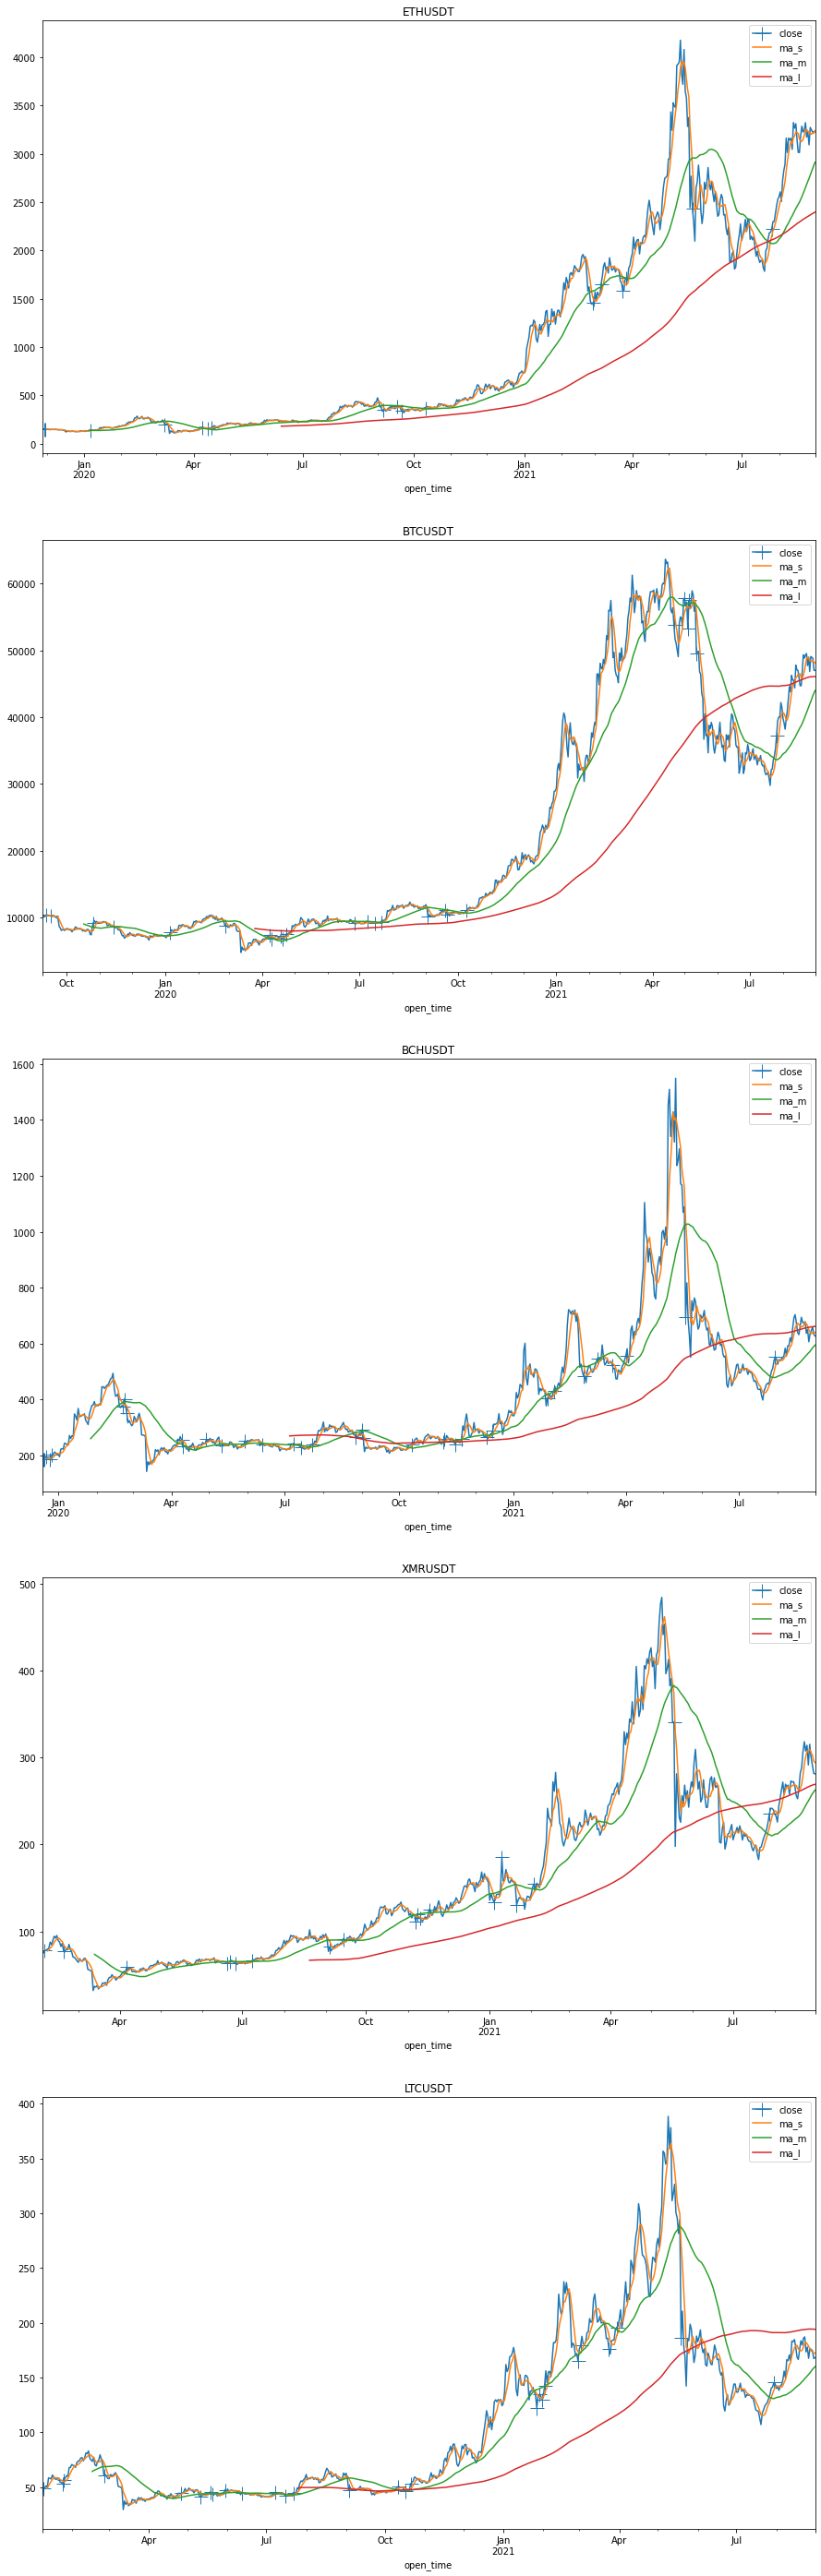

In [10]:
import matplotlib.pyplot as plt



fig, axes = plt.subplots(nrows=len(klines_dict), ncols=1)
for i, symbol in enumerate(klines_dict):
    markers = list(klines_dict.get(symbol).df.cross.astype(bool))
    klines_dict.get(symbol).ma_close_df.plot(markevery=markers, ax=axes[i], title = symbol, 
                                          style = ['+-', '-', '-'], figsize = (15,50), markersize =15)


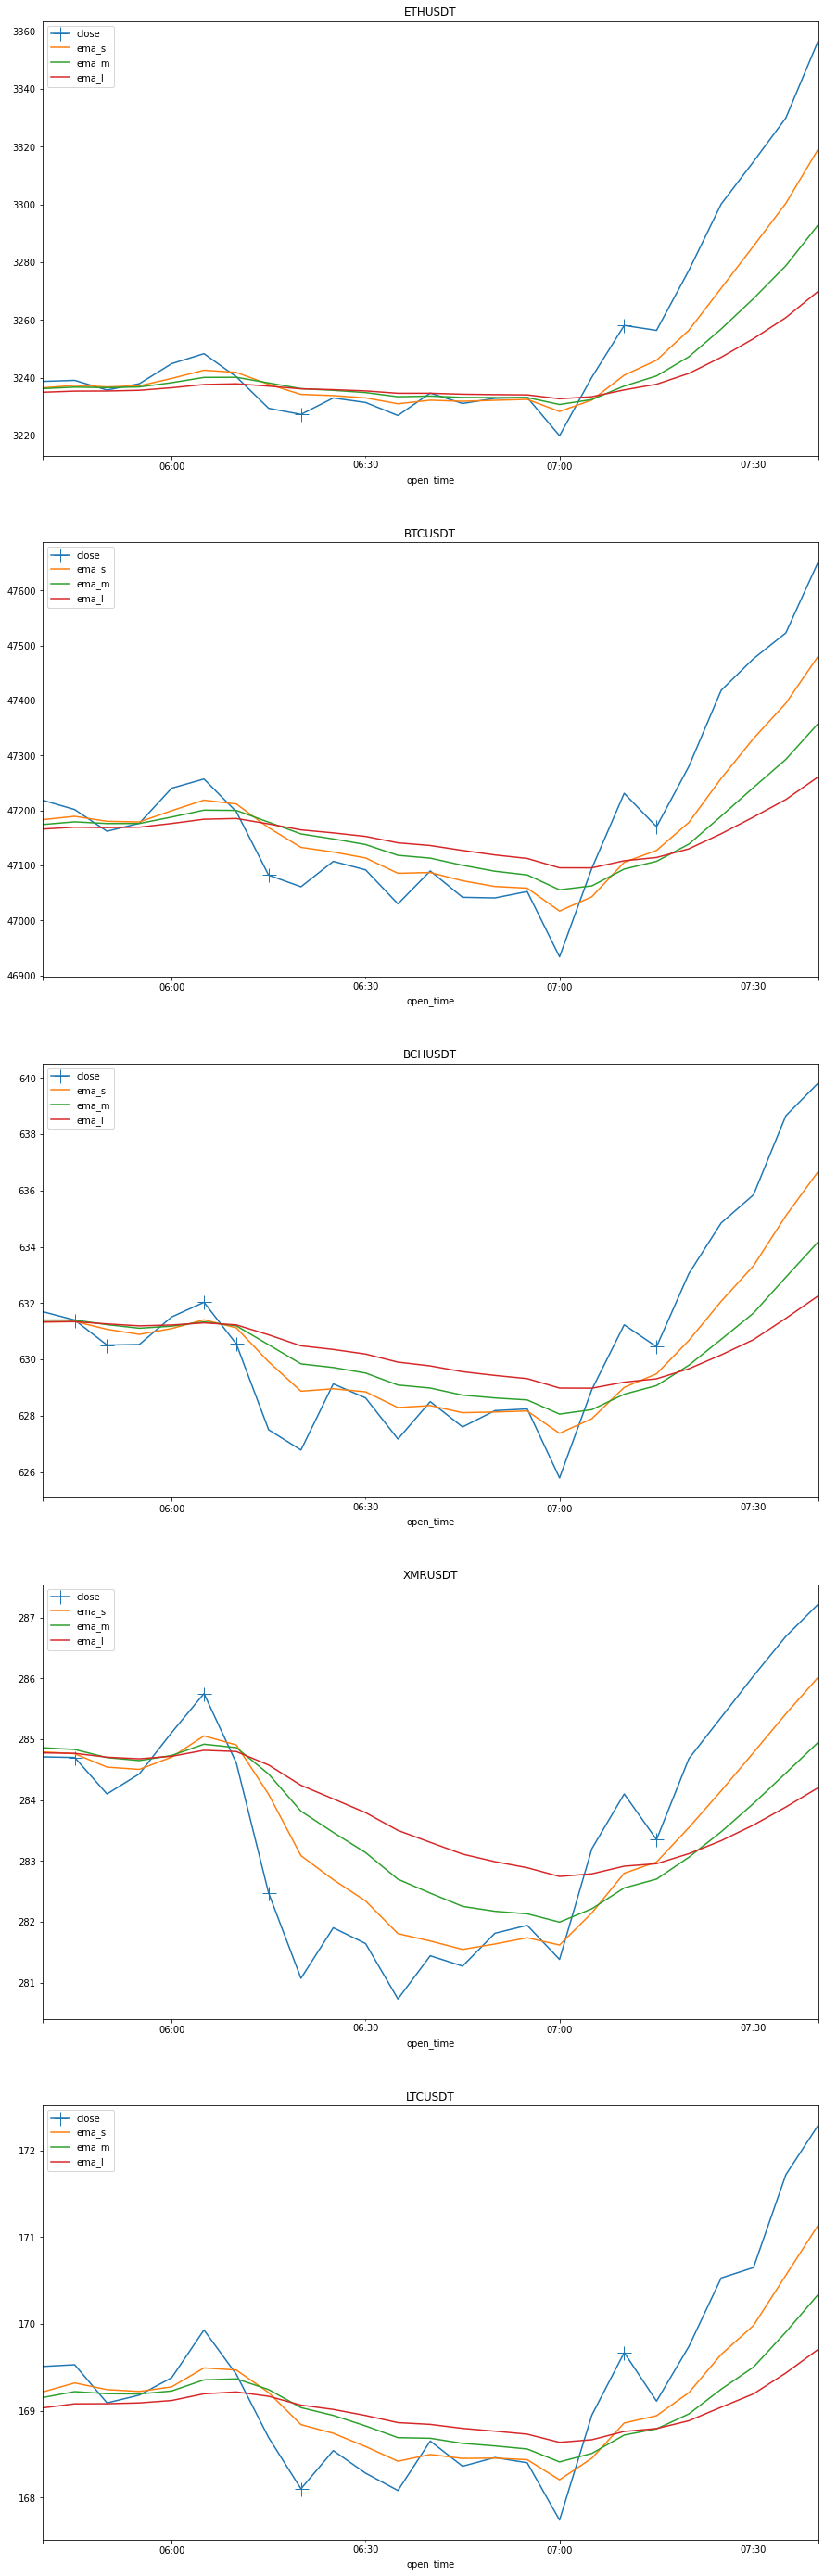

In [42]:
last_n_rows = 25


fig, axes = plt.subplots(nrows=len(klines_dict), ncols=1)
for i, symbol in enumerate(klines_dict):
    markers = list(klines_dict.get(symbol).df.cross.astype(bool))
    if not last_n_rows == "full":
        markers = markers[-last_n_rows:]
        klines_dict.get(symbol).ema_close_df[-last_n_rows:].plot(markevery=markers, ax=axes[i], title = symbol, 
                                          style = ['+-', '-', '-'], figsize = (15,50), markersize =15)
    else:
        klines_dict.get(symbol).ema_close_df.plot(markevery=markers, ax=axes[i], title = symbol, 
                                          style = ['+-', '-', '-'], figsize = (15,50), markersize =15)


In [117]:
# Max limit is 1000 and is weighted according to https://binance-docs.github.io/apidocs/futures/en/#order-book
# To understand weights, it means that you get 1200 weights per minute, and you are 'using up' these weights.
# limit of 500 costs 10 weights, whereas 1000 costs 20 weights
orders = client.futures_order_book(symbol = "ETHUSDT", limit = 500)

mo['asks']

[['3975.39', '0.002'],
 ['3975.49', '0.002'],
 ['3975.50', '0.002'],
 ['3975.52', '1.216'],
 ['3975.56', '0.002'],
 ['3975.57', '3.462'],
 ['3975.66', '1.040'],
 ['3975.68', '1.812'],
 ['3975.70', '0.400'],
 ['3975.74', '0.024'],
 ['3975.78', '0.745'],
 ['3975.79', '2.516'],
 ['3975.90', '4.573'],
 ['3975.91', '3.032'],
 ['3975.92', '10.000'],
 ['3975.93', '0.021'],
 ['3975.98', '5.898'],
 ['3975.99', '2.516'],
 ['3976.00', '2.735'],
 ['3976.04', '5.895'],
 ['3976.05', '5.499'],
 ['3976.12', '0.347'],
 ['3976.19', '0.769'],
 ['3976.27', '5.022'],
 ['3976.30', '0.802'],
 ['3976.33', '3.704'],
 ['3976.35', '3.772'],
 ['3976.36', '1.258'],
 ['3976.38', '2.891'],
 ['3976.39', '1.266'],
 ['3976.41', '0.037'],
 ['3976.42', '0.499'],
 ['3976.43', '7.100'],
 ['3976.44', '32.603'],
 ['3976.45', '0.252'],
 ['3976.46', '10.000'],
 ['3976.50', '62.440'],
 ['3976.53', '0.060'],
 ['3976.55', '0.787'],
 ['3976.56', '4.018'],
 ['3976.59', '8.245'],
 ['3976.60', '0.800'],
 ['3976.61', '3.880'],
 ['3976

In [115]:
# Merge dfs to predict ETH prices based on other cryptos

combined_df = klines_dict.get('ETHUSDT').close_df.copy(deep=True)

for symbol in klines_dict:
    if symbol == 'ETHUSDT':
        continue  
    column_name = f"{symbol}_close"
    combined_df[column_name] = klines_dict.get(symbol).close_df.close

combined_df

,close,ma_s,ma_l,DOGEUSDT_close,BTCUSDT_close,ETCUSDT_close,BCHUSDT_close,XRPUSDT_close,LTCUSDT_close
open_time,,,,,,,,,
2020-12-26 08:00:00,628.01,NaN,NaN,0.004501,24913.81,5.705,319.55,0.3081,128.73
2020-12-26 09:00:00,623.15,NaN,NaN,0.004486,24868.08,5.651,317.08,0.3023,128.50
2020-12-26 10:00:00,619.34,NaN,NaN,0.004455,24737.96,5.641,313.73,0.2964,127.14
2020-12-26 11:00:00,622.76,NaN,NaN,0.004469,24843.80,5.707,317.10,0.3026,129.37
2020-12-26 12:00:00,624.49,623.550,NaN,0.004511,24903.21,5.689,318.22,0.3062,130.15
...,...,...,...,...,...,...,...,...,...
2021-02-05 19:00:00,1712.62,1721.404,1655.64875,0.045763,37638.22,8.158,434.80,0.4415,151.76
2021-02-05 20:00:00,1722.85,1716.926,1657.08150,0.046394,37760.09,8.366,435.56,0.4455,152.64
2021-02-05 21:00:00,1722.22,1715.292,1658.68675,0.046530,37851.92,8.559,438.23,0.4453,153.12


In [20]:
from scipy import stats
import statsmodels.api as sm

print(sm.tsa.stattools.adfuller(combined_df.close))

(-0.8922554267016359, 0.7905121166039665, 0, 999, {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 8554.354112782587)


In [63]:
# Let's create a seasonal shift of 24 hours and then difference to get a SARIMA
df = combined_df.copy(deep=True)
df.drop(columns = ['ma_s', 'ma_l', 'close_1D', 'close_1Ds'], inplace=True)

for column in df.columns.copy():
    a = df[column].shift(1, freq = 'D')
    name = f"{column}_1D"
    seasonal_diff = df.close - a
    df[name] = seasonal_diff - seasonal_diff.shift(1)

df

,close,DOGEUSDT_close,BTCUSDT_close,ETCUSDT_close,BCHUSDT_close,XRPUSDT_close,LTCUSDT_close,close_1D,DOGEUSDT_close_1D,BTCUSDT_close_1D,ETCUSDT_close_1D,BCHUSDT_close_1D,XRPUSDT_close_1D,LTCUSDT_close_1D
open_time,,,,,,,,,,,,,,
2020-12-26 01:00:00,628.02,0.004558,24928.28,5.772,321.04,0.3090,129.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 02:00:00,626.62,0.004557,24858.51,5.768,317.30,0.3086,128.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 03:00:00,634.45,0.004646,24931.98,5.820,325.00,0.3192,131.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 04:00:00,630.70,0.004471,24832.95,5.784,320.53,0.3096,130.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-26 05:00:00,626.79,0.004520,24729.55,5.719,319.24,0.3114,128.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-05 12:00:00,1663.37,0.045702,37916.26,8.202,436.70,0.4530,153.34,-25.57,-2.195513,-308.39,-2.290,-5.05,-2.2021,-4.20
2021-02-05 13:00:00,1723.65,0.045777,38333.60,8.193,440.12,0.4475,155.71,64.37,60.278272,92.23,60.296,59.66,60.2759,59.42
2021-02-05 14:00:00,1738.94,0.046162,38138.52,8.145,440.28,0.4475,155.92,55.29,15.291552,810.68,15.418,24.48,15.2931,18.97


In [40]:
# Note that the slice of 25: is essential due to the seasonal differencing and first difference, 
# which removes 24+1 observations
print(sm.tsa.stattools.adfuller(df.close_1D[25:]))

(-22.722599123090514, 0.0, 1, 973, {'1%': -3.4370885772879083, '5%': -2.8645150193044464, '10%': -2.5683540564723377}, 9034.680513924533)
['close', 'DOGEUSDT_close', 'BTCUSDT_close', 'ETCUSDT_close', 'BCHUSDT_close', 'XRPUSDT_close', 'LTCUSDT_close', 'close_1D', 'DOGEUSDT_close_1D', 'BTCUSDT_close_1D', 'ETCUSDT_close_1D', 'BCHUSDT_close_1D', 'XRPUSDT_close_1D', 'LTCUSDT_close_1D']


In [64]:
import pmdarima as pm

# SARIMAX Model
exog_symbols = []
for c in df.columns:
    if 'USDT_close_1D' in c:
        exog_symbols.append(c)

        
sxmodel = pm.auto_arima(df[['close_1D']][25:], exogenous=df[exog_symbols][25:],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=9.28 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7862.269, Time=0.85 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7594.221, Time=9.35 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.58 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7860.270, Time=2.24 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7863.264, Time=1.38 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7499.213, Time=19.19 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=18.25 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=7497.926, Time=29.50 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=7593.415, Time=6.69 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=16.88 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.00 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=7499.099, Time=18.69 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=7

In [65]:
# Great results, but obviously unfeasible to have exogenous at time of prediction, only have the lagged observations
# I will rerun with lagged other coins instead.
sxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  975
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3738.980
Date:                  Fri, 05 Feb 2021   AIC                           7495.961
Time:                          19:06:18   BIC                           7539.791
Sample:                      12-27-2020   HQIC                          7512.650
                           - 02-05-2021                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DOGEUSDT_close_1D    25.0119     44.950      0.556      0.578     -63.089     113.113
BTCUSDT_close_1D      0.0147      0.001     17.114      0.000       0.013       0.016
ETCUSDT_close_1D     39.1636      2.321     16.870      0.000      34.614      43.714
BCHUSDT_close_1D      0.1361      0.069      1.986      0.047       0.002       0.270
XRPUSDT_close_1D    -66.0420     44.946     -1.469      0.142    -154.135      22.051
LTCUSDT_close_1D      2.7668      0.197     14.056      0.000       2.381       3.153
ar.S.L12             -0.6596      0.028    -23.347      0.000      -0.715      -0.604
ar.S.L24             -0.3294      0.028    -11.765      0.000      -0.384      -0.275
sigma2              137.0667      4.163     32.924      0.000     128.907     145.226
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               347.65
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.17
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [69]:
# The exogenous are shifted because at period t you only know about period t-1 realistically of the other prices.
sxmodel2 = pm.auto_arima(df[['close_1D']][26:800], exogenous=df[exog_symbols].shift(1)[26:800],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=8.34 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=7852.228, Time=0.58 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=7583.824, Time=6.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=4.46 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=7850.231, Time=1.35 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=7853.143, Time=1.43 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=7488.655, Time=18.51 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=25.32 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.72 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=7487.291, Time=24.81 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=7582.874, Time=13.92 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=15.57 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=8.21 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=7488.556, Time=18.42 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=

In [70]:
sxmodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                  974
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3733.765
Date:                  Fri, 05 Feb 2021   AIC                           7485.529
Time:                          19:22:59   BIC                           7529.350
Sample:                      12-27-2020   HQIC                          7502.215
                           - 02-05-2021                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DOGEUSDT_close_1D    25.8757     45.748      0.566      0.572     -63.789     115.540
BTCUSDT_close_1D      0.0148      0.001     16.944      0.000       0.013       0.016
ETCUSDT_close_1D     39.2407      2.361     16.621      0.000      34.613      43.868
BCHUSDT_close_1D      0.1397      0.069      2.010      0.044       0.003       0.276
XRPUSDT_close_1D    -66.9444     45.744     -1.463      0.143    -156.600      22.711
LTCUSDT_close_1D      2.7244      0.201     13.557      0.000       2.331       3.118
ar.S.L12             -0.6588      0.029    -22.943      0.000      -0.715      -0.603
ar.S.L24             -0.3289      0.028    -11.549      0.000      -0.385      -0.273
sigma2              139.4654      4.313     32.339      0.000     131.013     147.918
===================================================================================
Ljung-Box (L1) (Q):                   0.65   Jarque-Bera (JB):               354.61
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.17
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [104]:
# Results say that DOGE is the worst predictor of performance, which is quite reasonable XD
# Next model says that DOGE is not that bad of a predictor though ...
model=sm.tsa.statespace.SARIMAX(df.close_1D[26:800], exog = df[exog_symbols].shift(1)[26:800],
                                order=(0, 0, 0), seasonal_order=(2,1,0, 12)).fit(disp=-1)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                 close_1D   No. Observations:                  774
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood               -3688.721
Date:                  Fri, 05 Feb 2021   AIC                           7395.442
Time:                          23:13:26   BIC                           7437.165
Sample:                      12-27-2020   HQIC                          7411.507
                           - 01-28-2021                                         
Covariance Type:                    opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
DOGEUSDT_close_1D  -260.8997    181.464     -1.438      0.151    -616.563      94.764
BTCUSDT_close_1D     -0.0044      0.003     -1.494      0.135      -0.010       0.001
ETCUSDT_close_1D     -3.3129     10.139     -0.327      0.744     -23.185      16.559
BCHUSDT_close_1D      0.4389      0.162      2.702      0.007       0.121       0.757
XRPUSDT_close_1D    264.7184    180.772      1.464      0.143     -89.587     619.024
LTCUSDT_close_1D     -0.9330      0.601     -1.551      0.121      -2.112       0.246
ar.S.L12             -0.3600      0.028    -13.008      0.000      -0.414      -0.306
ar.S.L24             -0.6069      0.024    -25.537      0.000      -0.654      -0.560
sigma2              930.3369     39.128     23.777      0.000     853.647    1007.027
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.15
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.85   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
# note that the above sarimax is different from the one found by 
predictions = model.forecast(200, exog =df[exog_symbols].shift(1)[800:])
predictions

2021-01-28 09:00:00     1.292378
2021-01-28 10:00:00    -0.712353
2021-01-28 11:00:00    -1.292454
2021-01-28 12:00:00   -31.905738
2021-01-28 13:00:00     7.850434
                         ...    
2021-02-05 12:00:00    10.418951
2021-02-05 13:00:00    -0.701444
2021-02-05 14:00:00    15.664995
2021-02-05 15:00:00    25.436002
2021-02-05 16:00:00   -24.824431
Freq: H, Name: predicted_mean, Length: 200, dtype: float64

In [109]:
actual_values = df.close_1D[800:]
actual_values

open_time
2021-01-28 09:00:00    15.11
2021-01-28 10:00:00    -6.42
2021-01-28 11:00:00    29.38
2021-01-28 12:00:00     0.89
2021-01-28 13:00:00    53.61
                       ...  
2021-02-05 12:00:00   -25.57
2021-02-05 13:00:00    64.37
2021-02-05 14:00:00    55.29
2021-02-05 15:00:00    18.26
2021-02-05 16:00:00   -34.26
Name: close_1D, Length: 200, dtype: float64

<AxesSubplot:>

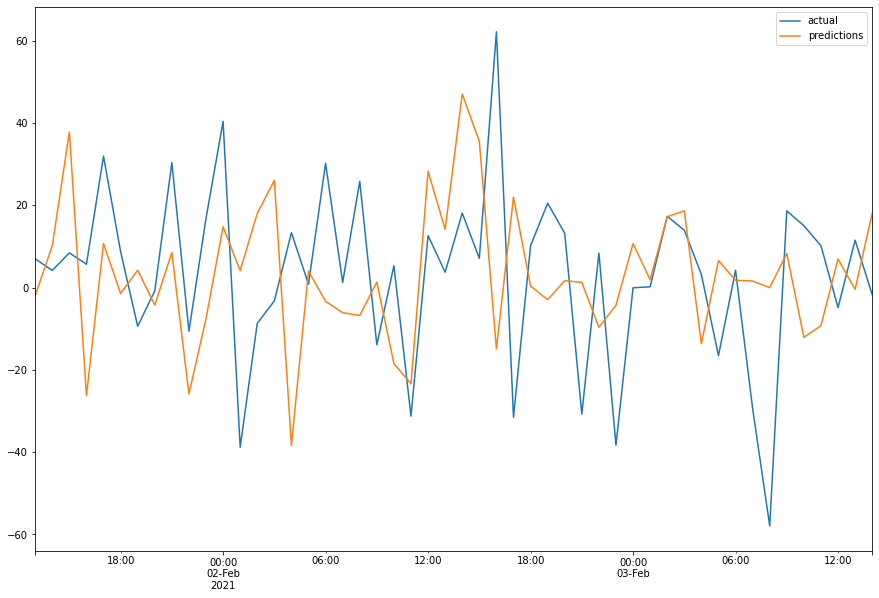

In [111]:
# Not great
compare_df = pd.DataFrame({"actual": actual_values, "predictions": predictions})
compare_df[100:150].plot(figsize = (15,10))